In [1]:
from dotenv import load_dotenv
from typing import Dict, List, Any, Annotated, TypedDict, Optional, Callable
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain.agents import create_agent, AgentState
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langsmith import traceable
from langgraph.types import interrupt, Command

from fnol_agent import call_agent as fnol_call_agent, resume_agent as fnol_resume_agent
from claim_agent import call_agent as claim_call_agent, resume_agent as claim_resume_agent

from uuid import uuid4
load_dotenv()

True

In [2]:
# Tools

def _extract_last_ai_content(messages: List[Any]) -> str:
    """Get the most recent AI response content from a sub-agent run."""
    for message in reversed(messages or []):
        if isinstance(message, AIMessage) and message.content:
            return message.content if isinstance(message.content, str) else str(message.content)
    if messages:
        last = messages[-1]
        return getattr(last, "content", str(last))
    return ""


def _invoke_sub_agent(
    call_fn: Callable[[str, Dict[str, Any]], Dict[str, Any]],
    resume_fn: Optional[Callable[[Any, Dict[str, Any]], Dict[str, Any]]],
    message: str,
    thread_id: Optional[str] = None,
) -> str:
    """Call a sub-agent, surfacing interrupts and returning its textual output."""
    agent_thread_id = thread_id or str(uuid4())
    agent_config = {"configurable": {"thread_id": agent_thread_id}}
    result = call_fn(message, agent_config)

    while True:
        if isinstance(result, dict):
            interruptions = result.get("__interrupt__", [])
            if interruptions:
                interrupt_obj = interruptions[-1]
                interrupt_payload = getattr(interrupt_obj, "value", interrupt_obj)
                if resume_fn is None:
                    interrupt(interrupt_payload)
                    return "Sub-agent interrupted."
                human_decision = interrupt(interrupt_payload)
                result = resume_fn(human_decision, agent_config)
                continue

            messages = result.get("messages", [])
            content = _extract_last_ai_content(messages)
            if content:
                return content
        return "Sub-agent returned no response."


@tool("fnol_agent_tool")
def fnol_agent_tool(email_text: str, thread_id: Optional[str] = None) -> str:
    """
    Run the specialized FNOL agent on the raw intake text.

    Args:
        email_text: Raw FNOL narrative from an insured or agent.
        thread_id: Optional identifier to resume a prior FNOL run.
    Returns:
        The FNOL agent's final textual summary (including the FNOL number).
    """
    return _invoke_sub_agent(fnol_call_agent, fnol_resume_agent, email_text, thread_id)


@tool("claim_agent_tool")
def claim_agent_tool(fnol_summary: str, thread_id: Optional[str] = None) -> str:
    """
    Run the claim setup agent using the FNOL summary and structured details.

    Args:
        fnol_summary: Output from the FNOL agent containing claim context.
        thread_id: Optional identifier to resume a prior claim run.
    Returns:
        The claim agent's final response (claim id or next action).
    """
    return _invoke_sub_agent(claim_call_agent, claim_resume_agent, fnol_summary, thread_id)


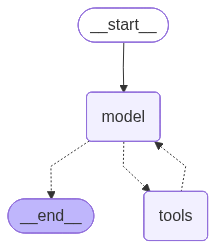

In [ ]:
# Agent

class OrchestratorState(AgentState):
    pass

# Tool and LLM definition
def get_tools():
    return [
        fnol_agent_tool,
        claim_agent_tool,
    ]


tools = get_tools()
llm = ChatOpenAI(model="gpt-5-nano", temperature=0.7)

# System Prompt
system_prompt = """
You are an orchestration assistant that coordinates two downstream agents via tools.

Workflow:
1. Always start by calling `fnol_agent_tool` with the raw intake email to create the FNOL in the system.
2. Feed the returned summary (plus any clarifications you add) into `claim_agent_tool` to create the claim, and capture the claim id.
3. Once `claim_agent_tool` completes, return its final answer (typically a claim_id). Do not fabricate IDs.
4. Send an email to the insured explaining that the claim has been created and providing the claim id.

General guidance:
- Pass along all relevant context when invoking each tool so downstream agents have the full story.
- If a tool response suggests human approval is needed, clearly explain the pending action so a human can intervene before resuming.
- Do not invent additional tool calls beyond the two provided; you are routing between FNOL and claim agents only.
"""


# Memory/Checkpointer for conversation persistence
memory = MemorySaver()

# Create agent using create_agent function
# Note: create_agent returns a compiled graph
agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_prompt,
    state_schema=OrchestratorState,
    checkpointer=memory
)

# Initial call to the agent
@traceable(run_type="llm", name="call_agent")
def call_agent(msg: str, config: Dict) -> Dict:
    message = (
        msg
        if isinstance(msg, (HumanMessage, AIMessage, ToolMessage, SystemMessage))
        else HumanMessage(content=msg)
    )
    return agent.invoke({"messages": [message]}, config=config)

# Resume the agent after human-in-the-loop input
@traceable(run_type="llm", name="resume_agent")
def resume_agent(decision: str, config: Dict) -> Dict:
    """Resume an interrupted agent execution with a decision."""
    print(f"[AGENT] Resuming with human decision: {decision}")
    result = agent.invoke(Command(resume=decision), config=config)
    print(f"[AGENT] Resume completed")
    return result



from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [4]:
email_text = """Subject: Need to Report a Water Leak – Policy HO3-77889900

Hi there,

I wanted to let you know that we had a water leak at my house yesterday and I need to open a claim.

On 2/19 around 2:35 PM, the supply line under our upstairs bathroom sink burst while no one was home. When we got back, water had leaked through the floor and into the living room ceiling, so there’s some noticeable damage to the ceiling and the flooring below.

We shut off the main water valve, had an emergency plumber come out to replace the broken line, and used buckets, towels, and fans overnight to keep things under control. No one was hurt, but the living room ceiling is sagging a bit.

I’m usually available most mornings if someone needs to come take a look.  
Weather was light rain yesterday, but this doesn’t seem related.

My details are:
- Name: John Doe  
- Email: john.doe@example.com  
- Policy Number: HO3-77889900  
- Address: 1245 Westbrook Ave, Austin, TX 78704  

Let me know what the next steps are or if you need photos (I haven’t taken any yet).

Thanks,  
John"""

THREAD_ID = str(uuid4())

config = {"configurable": {"thread_id": THREAD_ID}}

state = call_agent(email_text, config=config)



/Users/maxicorona/Projects/Britecore/1. Drafts/agentic-poc/.venv/lib/python3.13/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


In [5]:
state

{'messages': [HumanMessage(content='Subject: Need to Report a Water Leak – Policy HO3-77889900\n\nHi there,\n\nI wanted to let you know that we had a water leak at my house yesterday and I need to open a claim.\n\nOn 2/19 around 2:35 PM, the supply line under our upstairs bathroom sink burst while no one was home. When we got back, water had leaked through the floor and into the living room ceiling, so there’s some noticeable damage to the ceiling and the flooring below.\n\nWe shut off the main water valve, had an emergency plumber come out to replace the broken line, and used buckets, towels, and fans overnight to keep things under control. No one was hurt, but the living room ceiling is sagging a bit.\n\nI’m usually available most mornings if someone needs to come take a look.  \nWeather was light rain yesterday, but this doesn’t seem related.\n\nMy details are:\n- Name: John Doe  \n- Email: john.doe@example.com  \n- Policy Number: HO3-77889900  \n- Address: 1245 Westbrook Ave, Austi

In [ ]:
# Response from the claim agent asking for human input to proceed (human-in-the-loop)
state.get('__interrupt__')[-1].value

In [ ]:
human_subject = state.get('__interrupt__')[-1].value['subject']
human_body = state.get('__interrupt__')[-1].value['body'] + "\n\nPlease call us at 1-555-238-9021 to discuss the claim"

In [ ]:
decision = {
    "approved": True,
    "subject": human_subject,
    "body": human_body,
}
state = resume_agent(decision, {"configurable": {"thread_id": THREAD_ID}})

In [ ]:
existing_messages = state.get("messages", [])
existing_messages

In [ ]:
seen_ids = {getattr(msg, "id", None) for msg in existing_messages}
seen_ids